In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns

In [47]:
mcd = pd.read_csv('./kaggle/Mall_Customers.csv')

In [48]:
mcd.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [49]:
print('Mall Customers Data Info : ')
print(mcd.info())

Mall Customers Data Info : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


In [50]:
print(mcd.describe())

       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


In [51]:
print(mcd.isnull().sum())

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [52]:
print(mcd.duplicated().sum())

0


In [53]:
mcd.shape

(200, 5)

In [54]:
num_cols = mcd.select_dtypes(include=['int64']).columns

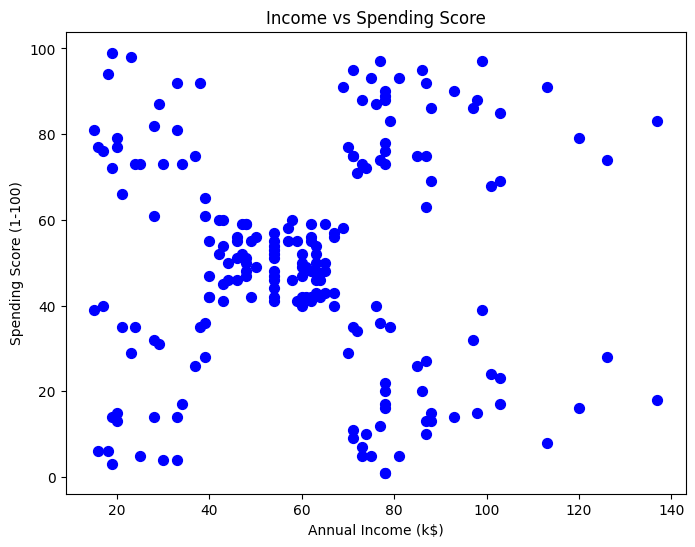

In [55]:
# Scatter plot to visualize groupings
plt.figure(figsize=(8,6))
plt.scatter(mcd['Annual Income (k$)'], mcd['Spending Score (1-100)'], c='blue', s=50)
plt.title('Income vs Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

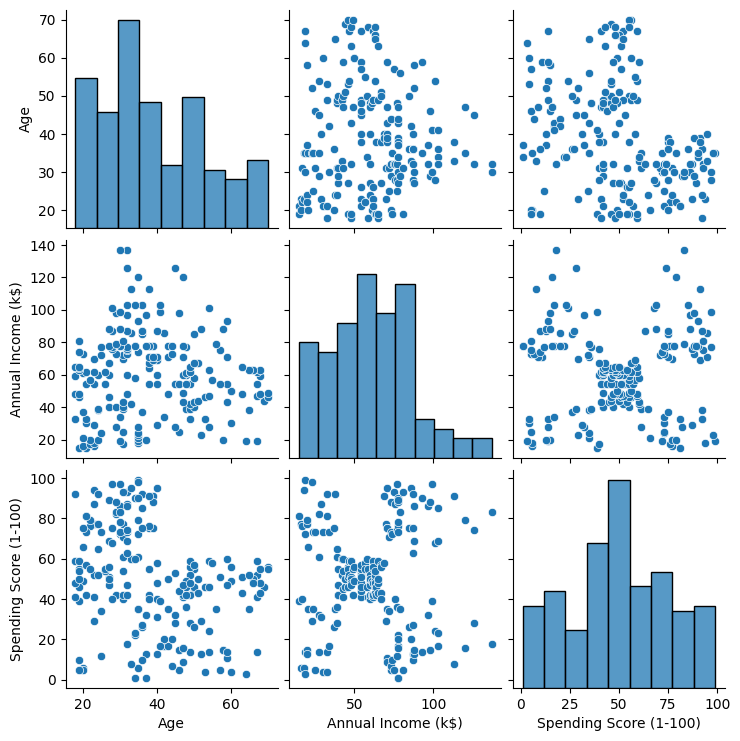

In [56]:
sns.pairplot(mcd[['Age','Annual Income (k$)','Spending Score (1-100)']])
plt.show()

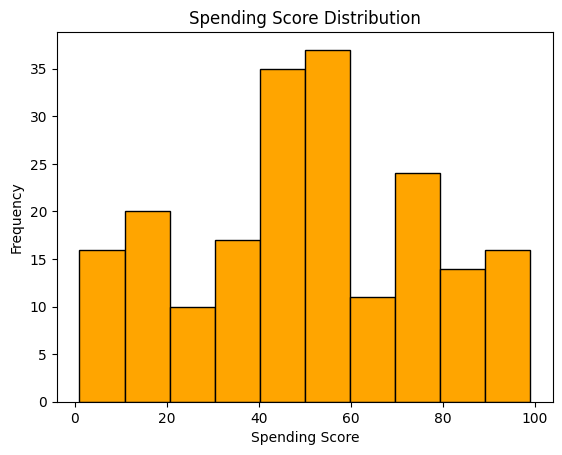

In [57]:
plt.hist(mcd['Spending Score (1-100)'], bins=10, color='orange', edgecolor='black')
plt.title('Spending Score Distribution')
plt.xlabel('Spending Score')
plt.ylabel('Frequency')
plt.show()

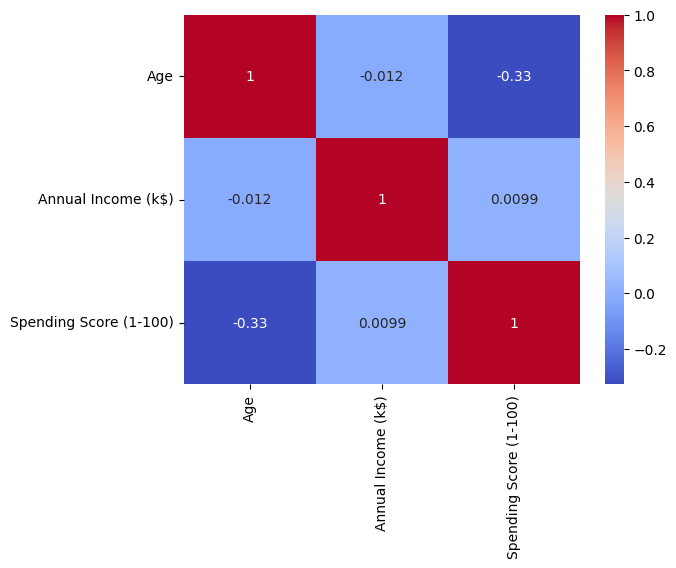

In [58]:
sns.heatmap(mcd[['Age','Annual Income (k$)','Spending Score (1-100)']].corr(), annot=True, cmap='coolwarm')
plt.show()

In [59]:
X = mcd[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

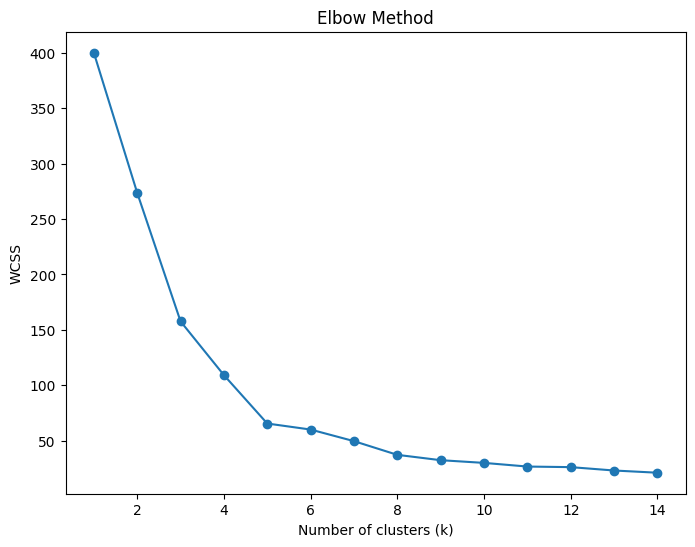

In [60]:
wcss = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS

# Plot WCSS vs k
plt.figure(figsize=(8,6))
plt.plot(range(1,15), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

In [61]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)

In [62]:
clusters = kmeans.fit_predict(X_scaled)

In [63]:
mcd['Cluster'] = clusters
mcd.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,4
1,2,Male,21,15,81,2
2,3,Female,20,16,6,4
3,4,Female,23,16,77,2
4,5,Female,31,17,40,4


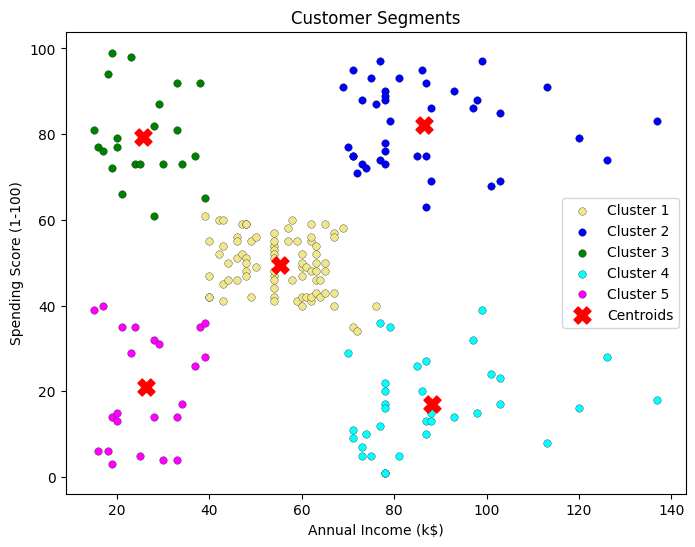

In [64]:
plt.figure(figsize=(8,6))

colors = ['khaki', 'blue', 'green', 'cyan', 'magenta']  # One color per cluster
for i in range(k):
    plt.scatter(mcd[mcd['Cluster']==i]['Annual Income (k$)'],
                mcd[mcd['Cluster']==i]['Spending Score (1-100)'],
                s=30, c=colors[i], label=f'Cluster {i+1}', edgecolors='black', linewidth = 0.2)

centroids = scaler.inverse_transform(kmeans.cluster_centers_)  # Convert back to original scale
plt.scatter(centroids[:,0], centroids[:,1], s=150, c='red', marker='X', label='Centroids')

plt.title('Customer Segments')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

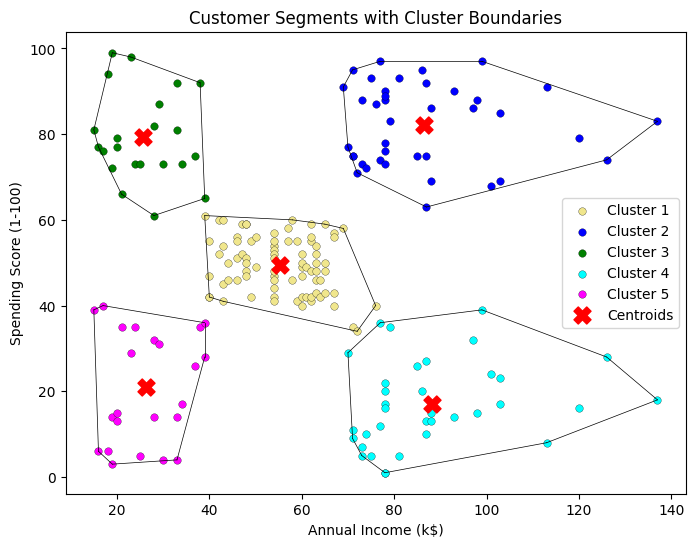

In [65]:
#clusters with boundaries
from scipy.spatial import ConvexHull

plt.figure(figsize=(8,6))

colors = ['khaki', 'blue', 'green', 'cyan', 'magenta']

for i in range(k):
    cluster_points = mcd[mcd['Cluster'] == i][['Annual Income (k$)', 'Spending Score (1-100)']].values

    # Scatter plot for each cluster
    plt.scatter(cluster_points[:,0], cluster_points[:,1],
                s=30, c=colors[i], label=f'Cluster {i+1}', edgecolors='black', linewidth=0.2)

    # Draw convex hull boundary if enough points
    if len(cluster_points) >= 3:
        hull = ConvexHull(cluster_points)
        for simplex in hull.simplices:
            plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-', linewidth=0.5)

# Plot centroids
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:,0], centroids[:,1], s=150, c='red', marker='X', label='Centroids')

plt.title('Customer Segments with Cluster Boundaries')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

In [66]:
db_mcd = mcd.copy()
db_mcd = db_mcd.drop('Cluster', axis=1)
dbscan = DBSCAN(eps=0.5,min_samples=5)
db_clusters = dbscan.fit_predict(X_scaled)
db_mcd['db_cluster'] = db_clusters

In [67]:
db_mcd.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),db_cluster
0,1,Male,19,15,39,0
1,2,Male,21,15,81,0
2,3,Female,20,16,6,0
3,4,Female,23,16,77,0
4,5,Female,31,17,40,0


<function matplotlib.pyplot.show(close=None, block=None)>

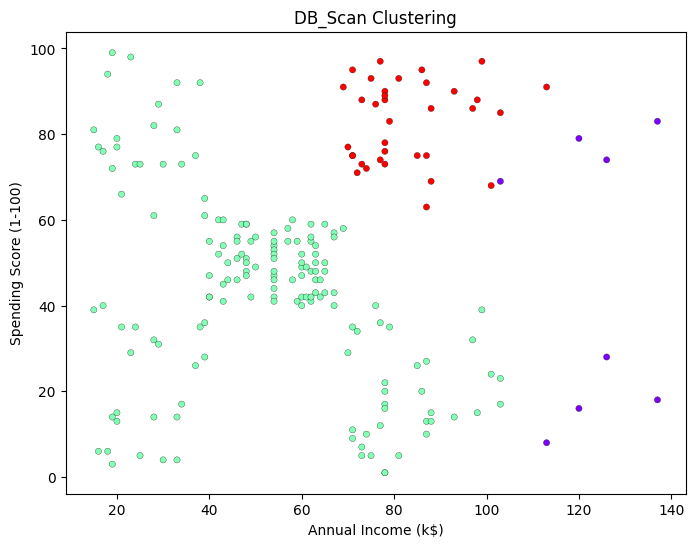

In [68]:
plt.figure(figsize=(8,6))
plt.scatter(db_mcd['Annual Income (k$)'], db_mcd['Spending Score (1-100)'], c=db_clusters, cmap='rainbow', s=20, edgecolors='black',linewidth=0.2)
plt.title('DB_Scan Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show

In [69]:
cluster_analysis = mcd.groupby('Cluster')[['Annual Income (k$)', 'Spending Score (1-100)']].mean()
print(cluster_analysis)


         Annual Income (k$)  Spending Score (1-100)
Cluster                                            
0                 55.296296               49.518519
1                 86.538462               82.128205
2                 25.727273               79.363636
3                 88.200000               17.114286
4                 26.304348               20.913043


In [70]:
db_cluster_analysis = db_mcd.groupby('db_cluster')[['Annual Income (k$)', 'Spending Score (1-100)']].mean()
print(db_cluster_analysis)

            Annual Income (k$)  Spending Score (1-100)
db_cluster                                            
-1                  122.750000               46.875000
 0                   52.490446               43.101911
 1                   82.542857               82.800000
